## Bachelor Arbeit:

Wie stark sind die Auswirkungen von Transfer Learning bezüglich der Effizienz und Effektivität anhand des Beispiels Autokennzeichen, wenn die erhebbaren Daten begrenzt sind?
***
How strong is the impact of transfer learning regarding the efficiency and effectiveness of convolutional neural networks, based on the example of detecting vehicle registration plates, assuming working with limited datasets?

In [1]:
# install required packages
!pip install fiftyone
!pip install keras
!pip install tensorflow
!pip install tflite-model-maker

  Using cached fiftyone_brain-0.9.2-py3-none-any.whl (49 kB)


  Using cached flatbuffers-22.12.6-py2.py3-none-any.whl (26 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


  Using cached tflite_model_maker-0.4.2-py3-none-any.whl (577 kB)
  Using cached tensorflow_datasets-4.7.0-py3-none-any.whl (4.7 MB)
  Using cached tensorflow_addons-0.19.0-cp39-cp39-win_amd64.whl (742 kB)
  Using cached numba-0.53.0-cp39-cp39-win_amd64.whl (2.3 MB)
  Using cached fire-0.4.0-py2.py3-none-any.whl
  Using cached neural_structured_learning-1.4.0-py2.py3-none-any.whl (128 kB)
  Using cached tflite_model_maker-0.4.1-py3-none-any.whl (642 kB)
  Using cached tflite_support_nightly-0.4.4.dev20221106-cp39-cp39-win_amd64.whl (469 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tflite_model_maker-0.4.0-py3-none-any.whl (642 kB)
  Using cached tflite_support-0.4.3-cp39-cp39-win_amd64.whl (469 kB)
  Using cached matplotlib-3.4.3-cp39-cp39-win_amd64.whl (7.1 MB)
  Using cached tflite_model_maker-0.3.4-py3-none-any.whl (616 kB)
  Using cached librosa-0.8.1-py3-none-any.whl (203 kB)
  Using cached tf_models_official-2.3.0-py2.py3-none-any.whl (840 kB)
 

ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


### Dataset

Zuerst werden in den folgenden Codezeilen Trainings-, Test- und Validationsdaten von der Open Images Datenbank (https://storage.googleapis.com/openimages/web/visualizer/index.html?type=detection&set=train&c=%2Fm%2F01jfm_) heruntergeladen. Dazu wird die von Google empfohlene FiftyOne Bibliothek verwendet (https://voxel51.com/docs/fiftyone/). Als Trainings-, Test- und Validationsgrundlage werden 400 Bilder (mit Autokennzeichen und mit Hunden) inklusive Ground-Truth geladen.

In [1]:
# download data from Open Image Dataset V6
# https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#open-images-v6
import os
import fiftyone

NUM_SAMPLES = 400

DATA_DIR = os.path.join(os.getcwd(), 'data')
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    
dataset = fiftyone.zoo.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types="classifications",
    classes=["Vehicle registration plate", "Dog"],
    max_samples=NUM_SAMPLES,
    dataset_dir=DATA_DIR,
    only_matching=True
)

 100% |██████|    4.8Gb/4.8Gb [1.1m elapsed, 0s remaining, 72.3Mb/s]      
 100% |███████████████████| 400/400 [24.7s elapsed, 0s remaining, 11.8 files/s]      
Dataset info written to 'C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\info.json'
Loading 'open-images-v6' split 'train'
 100% |█████████████████| 400/400 [398.9ms elapsed, 0s remaining, 1.0K samples/s]       
Dataset 'open-images-v6-train-400' created


Datensatz:
 <bound method SampleCollection.count of Name:        open-images-v6-train-400
Media type:  image
Num samples: 400
Persistent:  False
Tags:        []
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    positive_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    negative_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    open_images_id:  fiftyone.core.fields.StringField>
Erstes Bild:
 Filepath:  C:\Users\Benni\Desktop\PythonProjects\BA\bachelor-thesis-transfer-learning\data\train\data\0000048549557964.jpg 
 Tags:  ['train'] 
 Vehicle registration plate label:  True 
 None


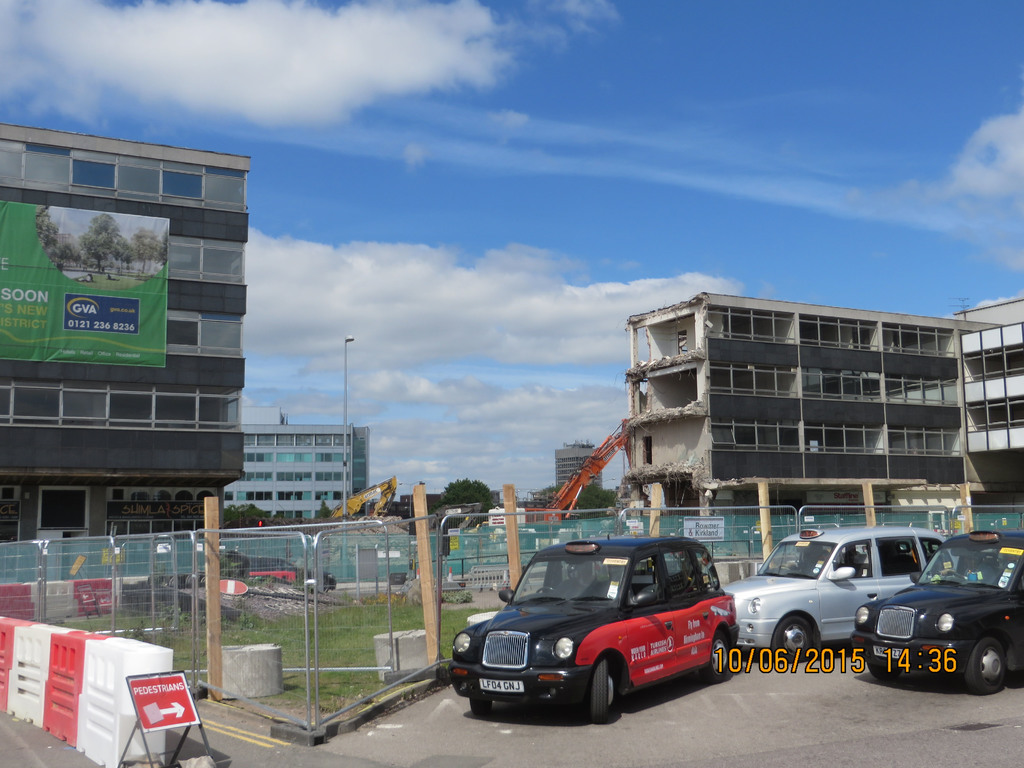

In [2]:
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

print("Datensatz:\n", dataset.count)
print("\nErstes Bild:\n",
      'Filepath: ', dataset.first().filepath, "\n",
      'Tags: ', dataset.first()['tags'], "\n",
      'Vehicle registration plate label: ', dataset.first()['positive_labels']['classifications'][0]['label'] == 'Vehicle registration plate', "\n",
      dataset.first()['metadata'])

array_to_img(load_img(dataset.first().filepath))

#### Preprocessing

1) Zuerst müssen die geladenen Daten in Trainings-, Test- und Validationsset unterteilt werden. Googles Open Image Dataset weist Bildern mehrere Tags wie zum Beispiel "train" oder "test" zu. Es kann jedoch auch vorkommen, dass ein Bild sowohl als Test- als auch als Trainingssample markiert ist. Deswegen müssen zuerst alle Markierungen aufgehoben werden und dann erneut zugewiesen werden.

2) Danach werden die Datensätze nach dem jeweiligen Tag gefiltert und die Bilder dieser Markierung in einer einheitlichen Größe (512x512) in ein numpy Array geladen, um sie später in ein Convolutional Neural Network füttern zu können. Außerdem werden die Bildwerte von einem 0-255 Zahlenraum in Gleitkommazahlen zwischen 0-1 skaliert. Dies hat den Hintergrund, dass zukünftige CNN-Berechnungen durch das fixe 0-1 Intervall erheblich vereinfacht werden und beispielsweise kein Risiko eines Overflows besteht.

Sample split/tags:  {'train': 280, 'validation': 60, 'test': 60}
X_train[0].shape:  (512, 512, 3)
First 10 labels of y_train:  [1 1 1 0 0 0 1 1 1 1]
5th image of X_train with label = 0:


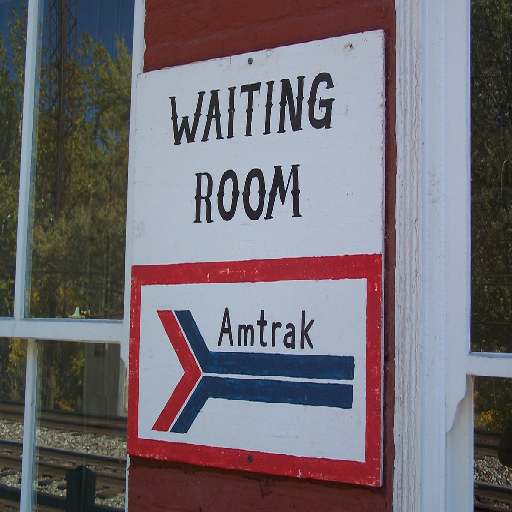

In [9]:
import numpy as np

# 1) split dataset into train (70%), test (15%) and validation (15%)
dataset.untag_samples("train")
dataset.untag_samples("test")
dataset.untag_samples("validation")

dataset[:NUM_SAMPLES*0.7].tag_samples("train")
dataset[NUM_SAMPLES*0.7:NUM_SAMPLES*0.85].tag_samples("test")
dataset[NUM_SAMPLES*0.85:].tag_samples("validation")

print("Sample split/tags: ", dataset.count_sample_tags())

# 2.1) load training and validation images in IMG_DIM format and scale to 0-1 float32
IMG_DIM = (512, 512)

train_view = dataset.match_tags("train")
X_train = np.array([img_to_array(load_img(img.filepath, target_size=IMG_DIM)) for img in train_view])
X_train = X_train.astype('float32')
X_train /= 255

val_view = dataset.match_tags("validation")
X_val = np.array([img_to_array(load_img(img.filepath, target_size=IMG_DIM)) for img in val_view])
X_val = X_val.astype('float32')
X_val /= 255

print("X_train[0].shape: ", X_train[0].shape)
array_to_img(X_train[0])

# 2.2) load training and validation ground_truth of dataset detection labels
y_train = np.array([
    any(classification['label'] == 'Vehicle registration plate'
        for classification in sample['positive_labels']['classifications'])
    for sample in train_view])
y_train = y_train.astype(int)

y_val = np.array([
    any(classification['label'] == 'Vehicle registration plate'
        for classification in sample['positive_labels']['classifications'])
    for sample in val_view])
y_val = y_val.astype(int)

print("First 10 labels of y_train: ", y_train[:10])
print("5th image of X_train with label = 0:")
array_to_img(X_train[4])

3) Als letzten Vorverarbeitungsschritt wird auf Basis des ImageDataGenerator der Keras Bibliothek (ein Algorithmus zur zufälligen Bildgenerierung - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) der vorhandene Datensatz erweitert. Dieser Schritt wird oftmals auch Bilderweiterung genannt und ist eine übliche Vorgehensweise, wenn die Daten begrenzt sind. Bilderweiterung erlaubt es durch Diversifizierung (Abändern der Bildparameter wie die Drehung des Bildes, das Format,...) ein Model mit mehreren unterschiedlichen Samples zu füttern und somit das Risiko von Overfitting zu minimieren.

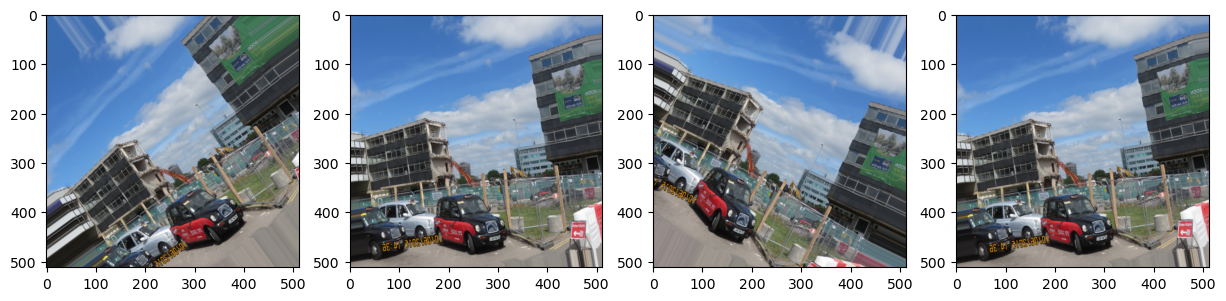

In [13]:
from keras.preprocessing.image import ImageDataGenerator
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

# 3) setup image augmentation algorithm
#TODO adapt Datagen to fit my requirements
X_train_datagen = ImageDataGenerator(rotation_range=20, shear_range=0.2,
                                     horizontal_flip=True, fill_mode='nearest')

# example image:
generator = X_train_datagen.flow(X_train[:1], y=y_train[:1], batch_size=1)
image = [next(generator) for i in range(4)]
fig, ax = plt.subplots(1, 4, figsize=(15, 6))
l = [ax[i].imshow(image[i][0][0]) for i in range(4)]

#### Transfer Learning

Für das Transfer Learning wird die Tensorflow Lite Model Maker Bibliothek herangezogen.

In [ ]:
from tflite_model_maker import image_classifier
from tflite_model_maker.image_classifier import DataLoader

# Load input data specific to an on-device ML app.
data = DataLoader.from_folder('flower_photos/')
train_data, test_data = data.split(0.9)

# Customize the TensorFlow model.
model = image_classifier.create(train_data)

# Evaluate the model.
loss, accuracy = model.evaluate(test_data)

# Export to Tensorflow Lite model and label file in `export_dir`.
model.export(export_dir='/tmp/')

In [ ]:
#for evaluation https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#evaluating-detections-open-images ?
results = dataset.evaluate_detections("predictions", gt_field="detections", method="open-images")